# 积分

## 符号积分

积分与求导的关系：

$$\frac{d}{dx} F(x) = f(x)
\Rightarrow F(x) = \int f(x) dx$$

符号运算可以用 `sympy` 模块完成。

先导入 `init_printing` 模块方便其显示：

In [1]:
from sympy import init_printing
init_printing()

In [2]:
from sympy import symbols, integrate
import sympy

产生 x 和 y 两个符号变量，并进行运算：

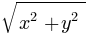

In [3]:
x, y = symbols('x y')
sympy.sqrt(x ** 2 + y ** 2)

对于生成的符号变量 `z`，我们将其中的 `x` 利用 `subs` 方法替换为 `3`：

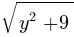

In [4]:
z = sympy.sqrt(x ** 2 + y ** 2)
z.subs(x, 3)

再替换 `y`：

In [5]:
z.subs(x, 3).subs(y, 4)

还可以从 `sympy.abc` 中导入现成的符号变量：

In [6]:
from sympy.abc import theta
y = sympy.sin(theta) ** 2
y

对 y 进行积分：

In [7]:
Y = integrate(y)
Y

计算 $Y(\pi) - Y(0)$：

In [8]:
import numpy as np
np.set_printoptions(precision=3)

Y.subs(theta, np.pi) - Y.subs(theta, 0)

计算 $\int_0^\pi y d\theta$ ：

In [9]:
integrate(y, (theta, 0, sympy.pi))

显示的是字符表达式，查看具体数值可以使用 `evalf()` 方法，或者传入 `numpy.pi`，而不是 `sympy.pi` ：

In [10]:
integrate(y, (theta, 0, sympy.pi)).evalf()

In [11]:
integrate(y, (theta, 0, np.pi))

根据牛顿莱布尼兹公式，这两个数值应该相等。

产生不定积分对象：

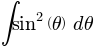

In [12]:
Y_indef = sympy.Integral(y)
Y_indef

In [13]:
print type(Y_indef)

<class 'sympy.integrals.integrals.Integral'>


定积分：

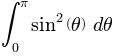

In [14]:
Y_def = sympy.Integral(y, (theta, 0, sympy.pi))
Y_def

产生函数 $Y(x) = \int_0^x sin^2(\theta) d\theta$，并将其向量化：

In [15]:
Y_raw = lambda x: integrate(y, (theta, 0, x))
Y = np.vectorize(Y_raw)

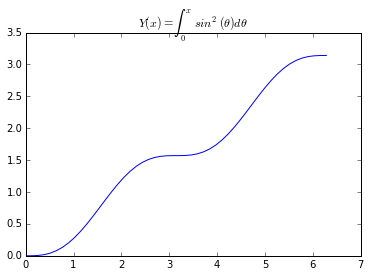

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
p = plt.plot(x, Y(x))
t = plt.title(r'$Y(x) = \int_0^x sin^2(\theta) d\theta$')

## 数值积分

数值积分：

$$F(x) = \lim_{n \rightarrow \infty} \sum_{i=0}^{n-1} f(x_i)(x_{i+1}-x_i) 
\Rightarrow F(x) = \int_{x_0}^{x_n} f(x) dx$$

导入贝塞尔函数：

In [17]:
from scipy.special import jv

In [18]:
def f(x):
    return jv(2.5, x)

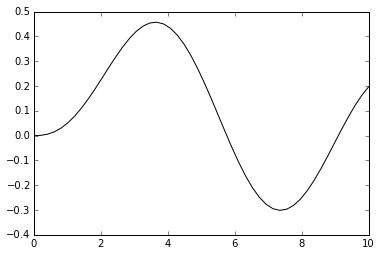

In [19]:
x = np.linspace(0, 10)
p = plt.plot(x, f(x), 'k-')

### `quad` 函数

Quadrature 积分的原理参见：

http://en.wikipedia.org/wiki/Numerical_integration#Quadrature_rules_based_on_interpolating_functions

quad 返回一个 (积分值，误差) 组成的元组：

In [20]:
from scipy.integrate import quad
interval = [0, 6.5]
value, max_err = quad(f, *interval)

积分值：

In [21]:
print value

1.28474297234


最大误差：

In [22]:
print max_err

2.34181853668e-09


积分区间图示，蓝色为正，红色为负：

integral = 1.284742972
upper bound on error: 2.34e-09


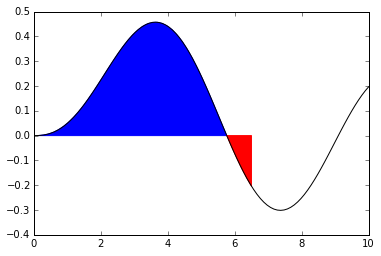

In [23]:
print "integral = {:.9f}".format(value)
print "upper bound on error: {:.2e}".format(max_err)
x = np.linspace(0, 10, 100)
p = plt.plot(x, f(x), 'k-')
x = np.linspace(0, 6.5, 45)
p = plt.fill_between(x, f(x), where=f(x)>0, color="blue")
p = plt.fill_between(x, f(x), where=f(x)<0, color="red", interpolate=True)

### 积分到无穷

In [24]:
from numpy import inf
interval = [0., inf]

def g(x):
    return np.exp(-x ** 1/2)

upper bound on error: 7.2e-11


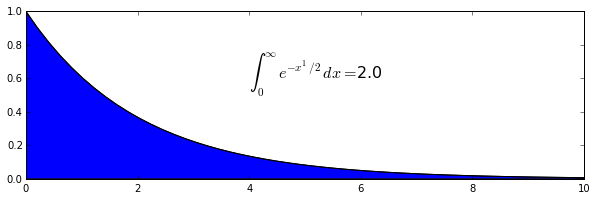

In [25]:
value, max_err = quad(g, *interval)
x = np.linspace(0, 10, 50)
fig = plt.figure(figsize=(10,3))
p = plt.plot(x, g(x), 'k-')
p = plt.fill_between(x, g(x))
plt.annotate(r"$\int_0^{\infty}e^{-x^1/2}dx = $" + "{}".format(value), (4, 0.6),
         fontsize=16)
print "upper bound on error: {:.1e}".format(max_err)

### 双重积分

假设我们要进行如下的积分：

$$ I_n = \int \limits_0^{\infty} \int \limits_1^{\infty} \frac{e^{-xt}}{t^n}dt dx = \frac{1}{n}$$

In [26]:
def h(x, t, n):
    """core function, takes x, t, n"""
    return np.exp(-x * t) / (t ** n)

一种方式是调用两次 `quad` 函数，不过这里 `quad` 的返回值不能向量化，所以使用了修饰符 `vectorize` 将其向量化：

In [27]:
from numpy import vectorize
@vectorize
def int_h_dx(t, n):
    """Time integrand of h(x)."""
    return quad(h, 0, np.inf, args=(t, n))[0]

In [28]:
@vectorize
def I_n(n):
    return quad(int_h_dx, 1, np.inf, args=(n))

In [29]:
I_n([0.5, 1.0, 2.0, 5])

(array([ 1.97,  1.  ,  0.5 ,  0.2 ]),
 array([  9.804e-13,   1.110e-14,   5.551e-15,   2.220e-15]))

或者直接调用 `dblquad` 函数，并将积分参数传入，传入方式有多种，后传入的先进行积分：

In [30]:
from scipy.integrate import dblquad
@vectorize
def I(n):
    """Same as I_n, but using the built-in dblquad"""
    x_lower = 0
    x_upper = np.inf
    return dblquad(h,
                   lambda t_lower: 1, lambda t_upper: np.inf,
                   x_lower, x_upper, args=(n,))

In [31]:
I_n([0.5, 1.0, 2.0, 5])

(array([ 1.97,  1.  ,  0.5 ,  0.2 ]),
 array([  9.804e-13,   1.110e-14,   5.551e-15,   2.220e-15]))

## 采样点积分

### trapz 方法 和 simps 方法

In [32]:
from scipy.integrate import trapz, simps

`sin` 函数， `100` 个采样点和 `5` 个采样点：

In [33]:
x_s = np.linspace(0, np.pi, 5)
y_s = np.sin(x_s)
x = np.linspace(0, np.pi, 100)
y = np.sin(x)

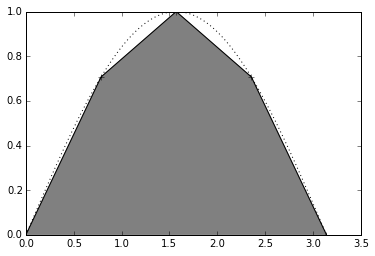

In [34]:
p = plt.plot(x, y, 'k:')
p = plt.plot(x_s, y_s, 'k+-')
p = plt.fill_between(x_s, y_s, color="gray")

采用 [trapezoidal 方法](https://en.wikipedia.org/wiki/Trapezoidal_rule) 和 [simpson 方法](https://en.wikipedia.org/wiki/Simpson%27s_rule) 对这些采样点进行积分（函数积分为 2）：

In [35]:
result_s = trapz(y_s, x_s)
result_s_s = simps(y_s, x_s)
result = trapz(y, x)
print "Trapezoidal Integration over 5 points : {:.3f}".format(result_s)
print "Simpson Integration over 5 points : {:.3f}".format(result_s_s)
print "Trapezoidal Integration over 100 points : {:.3f}".format(result)

Trapezoidal Integration over 5 points : 1.896
Simpson Integration over 5 points : 2.005
Trapezoidal Integration over 100 points : 2.000


### 使用 ufunc 进行积分

`Numpy` 中有很多 `ufunc` 对象：

In [36]:
type(np.add)

numpy.ufunc

In [37]:
np.info(np.add.accumulate)

accumulate(array, axis=0, dtype=None, out=None)

Accumulate the result of applying the operator to all elements.

For a one-dimensional array, accumulate produces results equivalent to::

  r = np.empty(len(A))
  t = op.identity        # op = the ufunc being applied to A's  elements
  for i in range(len(A)):
      t = op(t, A[i])
      r[i] = t
  return r

For example, add.accumulate() is equivalent to np.cumsum().

For a multi-dimensional array, accumulate is applied along only one
axis (axis zero by default; see Examples below) so repeated use is
necessary if one wants to accumulate over multiple axes.

Parameters
----------
array : array_like
    The array to act on.
axis : int, optional
    The axis along which to apply the accumulation; default is zero.
dtype : data-type code, optional
    The data-type used to represent the intermediate results. Defaults
    to the data-type of the output array if such is provided, or the
    the data-type of the input array if no output array is

`np.add.accumulate` 相当于 `cumsum` ：

In [38]:
result_np = np.add.accumulate(y) * (x[1] - x[0]) - (x[1] - x[0]) / 2

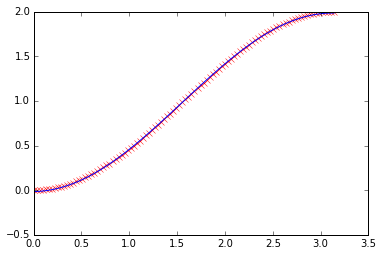

In [39]:
p = plt.plot(x, - np.cos(x) + np.cos(0), 'rx')
p = plt.plot(x, result_np)

### 速度比较

计算积分：$$\int_0^x sin \theta d\theta$$

In [40]:
import sympy
from sympy.abc import x, theta
sympy_x = x

In [41]:
x = np.linspace(0, 20 * np.pi, 1e+4)
y = np.sin(x)
sympy_y = vectorize(lambda x: sympy.integrate(sympy.sin(theta), (theta, 0, x)))

`numpy` 方法：

In [42]:
%timeit np.add.accumulate(y) * (x[1] - x[0])
y0 = np.add.accumulate(y) * (x[1] - x[0])
print y0[-1] 

The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 56.2 µs per loop
-2.34138044756e-17


`quad` 方法：

In [43]:
%timeit quad(np.sin, 0, 20 * np.pi)
y2 = quad(np.sin, 0, 20 * np.pi, full_output=True)
print "result = ", y2[0]
print "number of evaluations", y2[-1]['neval']

10000 loops, best of 3: 40.5 µs per loop
result =  3.43781337153e-15
number of evaluations 21


`trapz` 方法：

In [44]:
%timeit trapz(y, x)
y1 = trapz(y, x)
print y1

10000 loops, best of 3: 105 µs per loop
-4.4408920985e-16


`simps` 方法：

In [45]:
%timeit simps(y, x)
y3 = simps(y, x)
print y3

1000 loops, best of 3: 801 µs per loop
3.28428554968e-16


`sympy` 积分方法：

In [46]:
%timeit sympy_y(20 * np.pi)
y4 = sympy_y(20 * np.pi)
print y4

100 loops, best of 3: 6.86 ms per loop
0
